# Exploratory Data Analysis of Shoulder Data
Here we aim to expose the main characteristics of a dataset through statistical and visual tools, which can contribute significantly to design a proper solution to the problem of detection and classification of physical activity.

In [1]:
import os
import numpy as np
import pandas as pd
import pywt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime, timedelta
from openmovement.load import CwaData

### Patients' Dictionary - Loading CWA files into a dictionary of datasets
We write the following function to walk through the CWA files, read, re-sample and add into a single data structure.

In [2]:
def load_cwa(filename):
    with CwaData(filename, include_gyro=True, include_temperature=False) as cwa_data:
        samples = cwa_data.get_samples()
        samples = samples.set_index('time')
        samples = samples.astype('float32')
        samples = samples.resample('50ms').sum()
    return samples

In [3]:
def load_data(dir_dataset, pat_file_names):
    """
    Load data and creates a dictionary.

    Parameters:
    dir_dataset: directory of dataset files.

    Returns:
    Dictionary containing all files.

    """
    sensor_ds = {}

    for p in pat_file_names:
        idx = 0
        for cwa_f in os.listdir(os.path.join(dir_dataset, p, 'IMU')):
            idx += 1
            id_num = cwa_f.split('_')[1]
            file_name = os.path.join(dir_dataset, p, 'IMU', cwa_f)
            df = load_cwa(file_name)
            base_name = p + '_' + id_num + '_' + str(idx)
            sensor_ds[base_name] = df
    return sensor_ds

In [4]:
DIR_DATASET = os.path.join('..','Data')
pat_filenames = ['14']
sensor_ds = load_data(DIR_DATASET,pat_filenames)

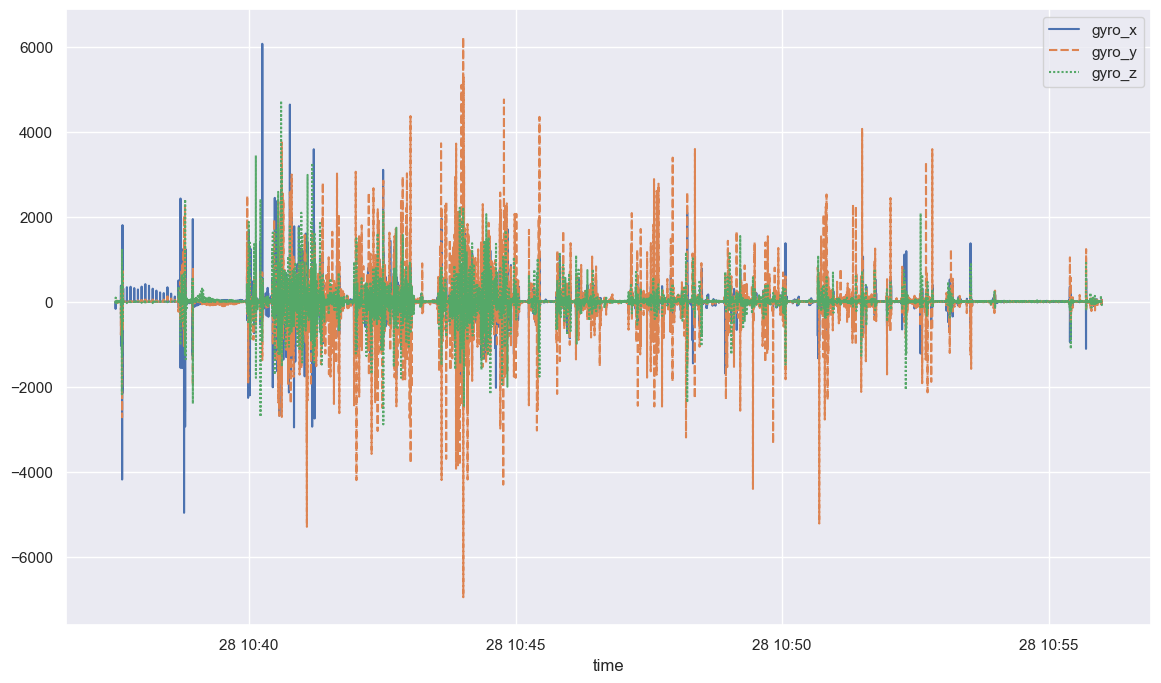

In [5]:
start_time = "2022-02-28 10:37"
end_time = "2022-02-28 10:55"

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=sensor_ds['14_543_1'][start_time:end_time].loc[:,['gyro_x','gyro_y','gyro_z']])
#ax.set_ylim(-0.01,0.01)

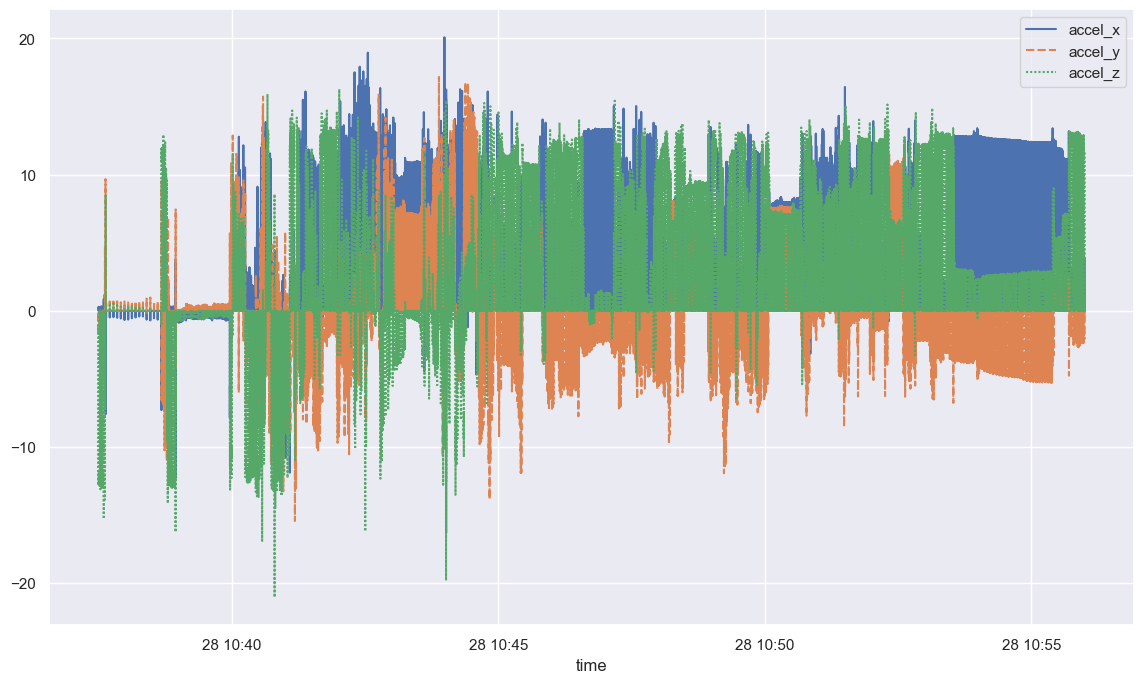

In [6]:
ax2 = sns.lineplot(data=sensor_ds['14_543_1'][start_time:end_time].loc[:,['accel_x','accel_y','accel_z']])

### Time window level analysis

In [ ]:
def plot_corr_file(df: pd.DataFrame, annot:bool, title:str, ax=None):
    """
    Plot a heatmat of correlations.

    Parameters:
    df: correlation dataframe.
    annot: including the numbers in the cells or not.
    ignore: features to exclude.
    title: title to show in the plot.
    ax: optional axes
    """
    axi = sns.heatmap(df,
                      cmap="YlGnBu",
                      vmax=1,
                      vmin=-1,
                      annot=annot,
                      ax=ax)
    axi.set_title(label=title)
    return axi

def plot_rolling_corr(corr_s: pd.Series, ax=None, plot_title='Rolling Correlation'):
    """
    Plot a rolling correlation.

    Parameters:
    corr_s: the rolling correlation.
    ax: axes.
    """
    fig, ax = plt.subplots(figsize=(15,3))
    plot_corr_file(np.array(corr_s).reshape((1,len(corr_s))), annot=False, title=plot_title, ax=ax)
    ax.set_yticks([]);
    return fig, ax

In [ ]:
xy_rolling_corr=sensor_ds['14_1'][start_time:end_time].accel_x.rolling(50).corr(sensor_ds['14_1'][start_time:end_time].accel_y)
plot_rolling_corr(xy_rolling_corr, plot_title='X-accel v/s Y-accel Correlation')

In [ ]:
xz_rolling_corr=sensor_ds['14_1'][start_time:end_time].accel_x.rolling(50).corr(sensor_ds['14_1'][start_time:end_time].accel_z)
plot_rolling_corr(xz_rolling_corr, plot_title='X-accel v/s Z-accel Correlation')

In [ ]:
yz_rolling_corr=sensor_ds['14_1'][start_time:end_time].accel_y.rolling(50).corr(sensor_ds['14_1'][start_time:end_time].accel_z)
plot_rolling_corr(yz_rolling_corr, plot_title='Y-accel v/s Z-accel Correlation')

### Add labels: Import timestamps of physical activity
In this section we import the Excel file with the timestamps that indicate the beggining of the physical activity at each measurement. In the mean time, we are going to assume that the exercises elapsed 30 minutes. We are going to add a boolean variable to each of the Pandas datasets that indicates whether there is physical activity or not.

In [7]:
def add_timestamps(dict_ds,ts_df):
    for cwa_f in dict_ds:
        dict_ds[cwa_f] = dict_ds[cwa_f].assign(phys=1)
        f_tag = int(cwa_f.split('_')[1])
        aux = ts_df[ts_df["record_id"]==f_tag].iloc[:,3:]
        for ax in aux.keys():
            for bx in aux[ax].keys():
                if not(pd.isna(aux[ax][bx])) and not(isinstance(aux[ax][bx],str)):
                    start_time = aux[ax][bx]
                    print('Subject No.'+str(f_tag)+': Physical activity at'+str(start_time))
                    delta_time = timedelta(minutes=30)
                    end_time = aux[ax][bx] + delta_time
                    dict_ds[cwa_f].loc[start_time:end_time,'phys'] = 2
    return dict_ds
                

In [8]:
timestamps = pd.read_excel('..\exercise_timestamps.xlsx')
sensor_ds = add_timestamps(sensor_ds,timestamps)

Subject No.543: Physical activity at2022-02-10 10:34:00
Subject No.543: Physical activity at2022-02-13 21:35:00
Subject No.543: Physical activity at2022-02-15 21:43:00
Subject No.543: Physical activity at2022-02-14 16:58:00
Subject No.543: Physical activity at2022-02-16 14:46:00
Subject No.543: Physical activity at2022-02-27 10:29:00
Subject No.543: Physical activity at2022-03-01 08:45:00
Subject No.543: Physical activity at2022-03-03 08:45:00
Subject No.543: Physical activity at2022-03-06 08:50:00
Subject No.543: Physical activity at2022-03-12 16:33:00
Subject No.543: Physical activity at2022-03-16 11:25:00
Subject No.543: Physical activity at2022-03-18 11:30:00
Subject No.543: Physical activity at2022-02-10 10:34:00
Subject No.543: Physical activity at2022-02-13 21:35:00
Subject No.543: Physical activity at2022-02-15 21:43:00
Subject No.543: Physical activity at2022-02-14 16:58:00
Subject No.543: Physical activity at2022-02-16 14:46:00
Subject No.543: Physical activity at2022-02-27 1

For visualization, we now plot the physical activity on a specific interval

In [9]:
sensor_ds['14_543_2']

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,phys
time,,,,,,,
2022-03-03 20:01:53.800,-0.178223,-0.051270,1.002441,-0.122070,-0.244141,0.732422,1
2022-03-03 20:01:53.850,-2.320801,-0.662598,13.038086,-1.037598,-3.784180,8.728027,1
2022-03-03 20:01:53.900,-2.145508,-0.601562,12.032715,-1.159668,-3.479004,8.178711,1
2022-03-03 20:01:53.950,-2.332520,-0.658691,13.025391,-1.098633,-3.295898,8.850098,1
2022-03-03 20:01:54.000,-2.320312,-0.653809,13.046875,-0.854492,-3.540039,8.666992,1
...,...,...,...,...,...,...,...
2022-03-08 14:39:21.650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2022-03-08 14:39:21.700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2022-03-08 14:39:21.750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1


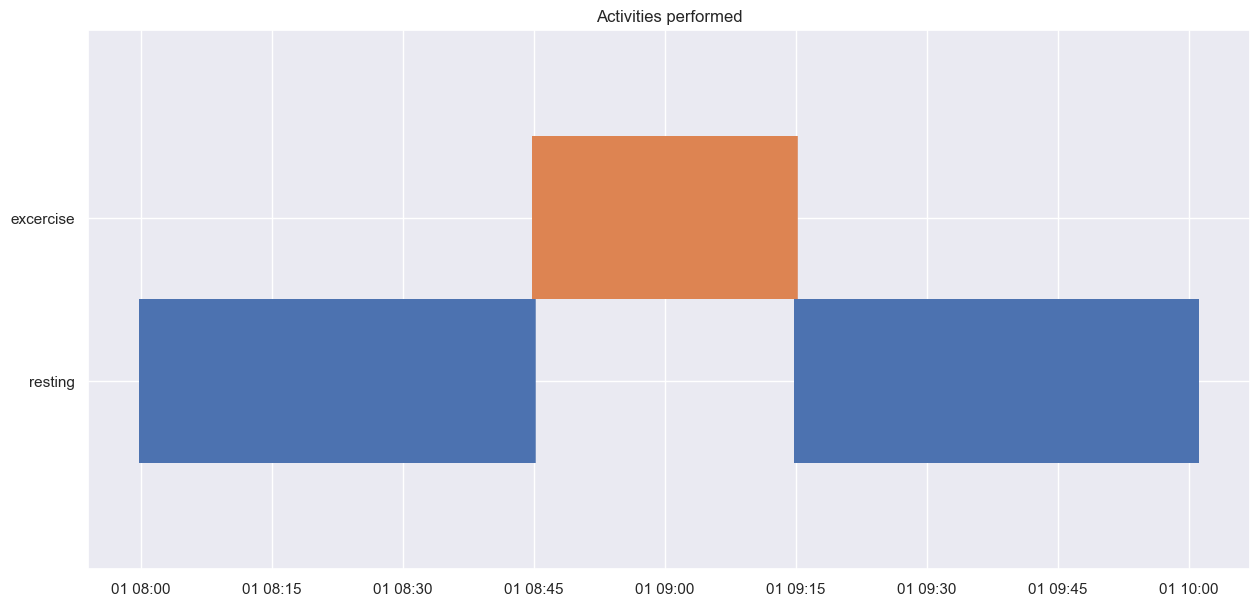

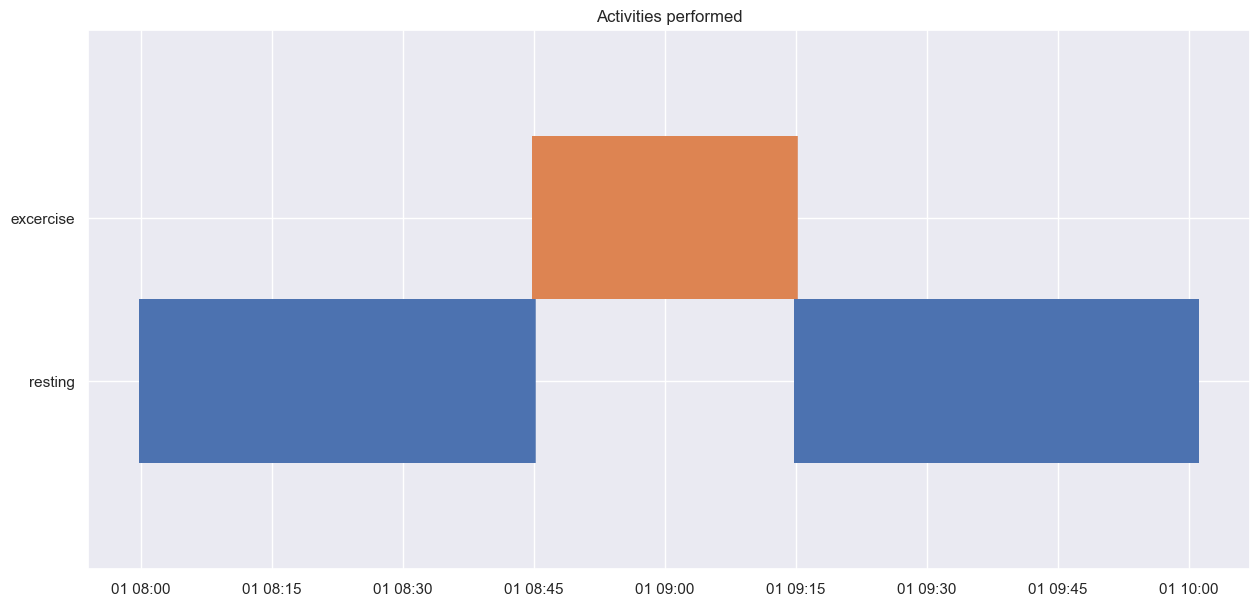

In [10]:
def activit_plot(pd_ds):
    labels = list()
    for i in range(1,3):
        labels.append(np.where(pd_ds.phys==i)[0])
    labels = [pd_ds.index[c] for c in labels]
    colors1 = ['C{}'.format(i) for i in range(len(labels))]
    # create a horizontal plot
    fig = plt.figure(figsize=(15,7))
    lineoffsets = [1,2]
    plt.eventplot(labels, colors=colors1, lineoffsets=lineoffsets)
    plt.yticks([1,2], ["resting", "excercise"])
    plt.title("Activities performed")
    return fig

start_time = "2022-03-01 08:00"
end_time = "2022-03-01 10:00"
activit_plot(sensor_ds['14_543_1'][start_time:end_time])

In [ ]:
# To remove added 'phys' attribute
# for pat in sensor_ds:
#     sensor_ds[pat] = sensor_ds[pat].drop('phys',axis=1)

### Detection of physical activity: Joint time & frequency analysis using DWT

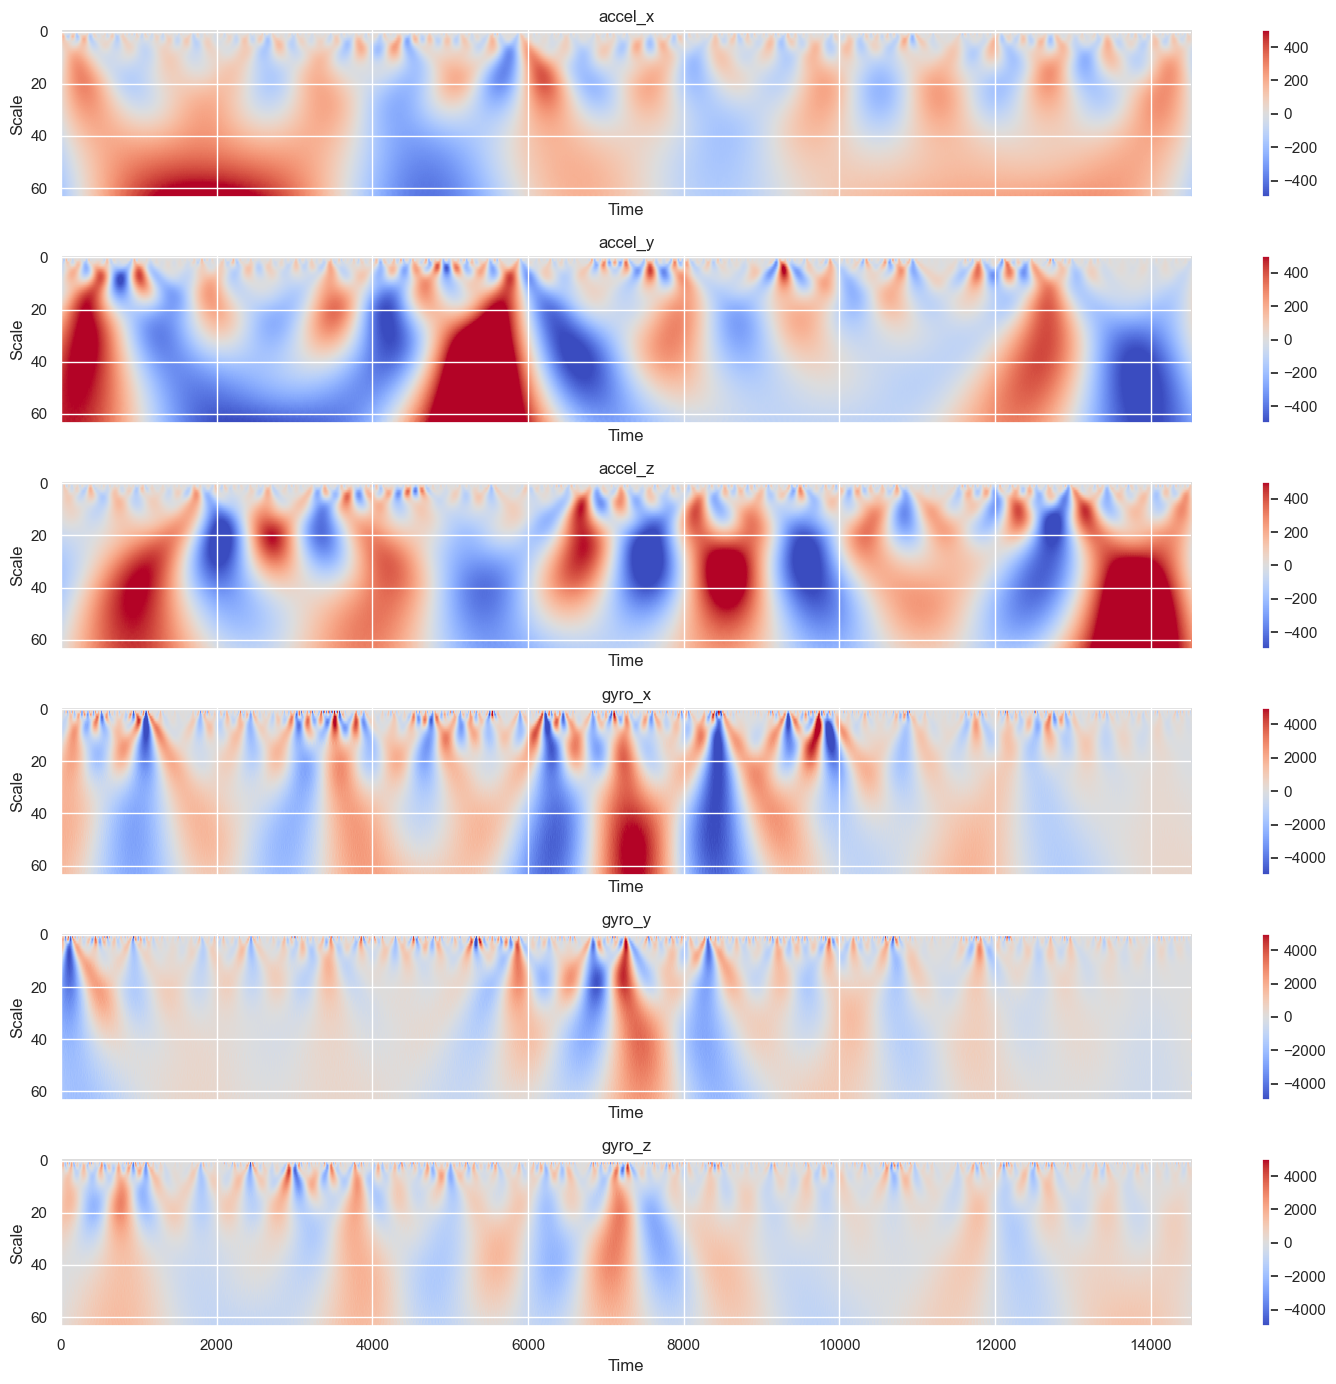

In [11]:
# create scalogram
# start_time = "2022-03-03 00:01"
# end_time = "2022-03-08 23:59"

X = sensor_ds['14_543_1'].resample('500ms').sum()
X = X[start_time:end_time]
fig, axs = plt.subplots(nrows=6, sharex=True, sharey=True, figsize=(15,14))
label_indicies = list(X.keys())
for ax, indices in zip(axs.flat, label_indicies):
    if indices.split('_')[0] == 'gyro':
        scales = np.arange(1,641,10)
        wavelet = 'mexh'
        vmin, vmax = -5000, 5000
    else:
        scales = np.arange(1,1025,16)
        wavelet = 'mexh'
        vmin, vmax = -500, 500
    # apply  PyWavelets continuous wavelet transfromation function
    coeffs, freqs = pywt.cwt(X[indices], scales, wavelet = wavelet)
    # create scalogram
    aux_ax = ax.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto', vmin=vmin, vmax=vmax)
    fig.colorbar(aux_ax, ax=ax)
    ax.set_title(indices)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('Scale')
    ax.set_xlabel('Time')
plt.tight_layout()

## Analyze laboratory data

Here we import the precisely-labelled data that was acquired at laboratory

In [ ]:
DIR_LAB_DATASET = os.path.join('..','Data-Experiment')
subject_idx = 2
subject_path = 'Subject%02d'%subject_idx
csv_path = 'Participant %03d Arm.csv'%subject_idx
imu_data_path = os.path.join(DIR_LAB_DATASET,subject_path,'IMU',csv_path)

df = pd.read_csv(imu_data_path, names=['timestamp', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z'],
                          header=None)
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.set_index('timestamp')
df = df.astype('float32')

In [ ]:
df.describe()

In [ ]:
activ_file = 'Timing_sheet.xlsx'
activ_data_path = os.path.join(DIR_LAB_DATASET,subject_path,activ_file)
activ_df = pd.read_excel(activ_data_path, header=0)

In [ ]:
def add_activ_to_df(df,activ):
    df = df.assign(exercise=np.nan)
    for act_idx in range(1,len(activ['start_time'])):
        start_time = activ['start_time'][act_idx]
        end_time = activ['end_time'][act_idx]
        df.loc[start_time:end_time,'exercise'] = activ['exercise'][act_idx]
    return df

In [ ]:
df_phys = add_activ_to_df(df,activ_df)

In [ ]:
df_phys

In [ ]:
def activit_plot_2(pd_ds):
    activs = [np.nan,'sh_press','lat_raise','bent_row','walk','jog']
    labels = list()
    for i in range(len(activs)):
        labels.append(np.where(pd_ds.exercise==activs[i])[0])
    labels = [pd_ds.index[c] for c in labels]
    colors1 = ['C{}'.format(i) for i in range(len(labels))]
    # create a horizontal plot
    fig = plt.figure(figsize=(15,7))
    lineoffsets = [i for i in range(len(activs))]
    print(len(labels),len(colors1),len(lineoffsets))
    plt.eventplot(labels, colors=colors1, lineoffsets=lineoffsets)
    plt.yticks(lineoffsets, activs)
    plt.title("Activities performed")
    return fig

activit_plot_2(df_phys)